In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

ModuleNotFoundError: No module named 'tqdm'

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epoches = 100
batch_size = 128
learning_rate = 0.001


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


### Visualize

In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


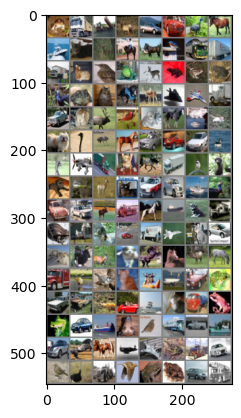

torch.Size([128, 3, 32, 32])


In [5]:
data_iter = iter(train_loader)
image = next(data_iter)[0]

imshow(torchvision.utils.make_grid(image))

conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
pool = nn.MaxPool2d(kernel_size=2, stride=2)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
print(image.shape)

x = conv1(image)
x = pool(x)
x = conv2(x)
x = pool(x)

# transform = torchvision.transforms.ToPILImage()
# img = transform(image)
# from PIL import Image


#img.show()




(array([121., 407., 506., 552., 493., 514., 197., 132., 100.,  50.]),
 array([-1.        , -0.80000001, -0.60000002, -0.39999998, -0.19999999,
         0.        ,  0.20000005,  0.39999998,  0.60000002,  0.80000007,
         1.        ]),
 <BarContainer object of 10 artists>)

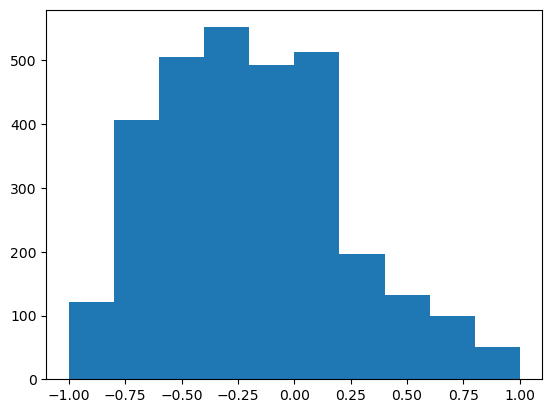

In [6]:

#dataset after transformation
plt.hist(image[0].flatten())

### Model

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features = 16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x =self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



model = ConvNet()
model = model.to(device)


In [8]:

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#training loop
epoch_bar = tqdm(desc="epoch bar", total=num_epoches, position=0)
train_bar = tqdm(desc="training bar", total=len(train_loader), position=1)

for i in range(num_epoches):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #forward pass
        output = model(images)
        l = loss(output, labels)

        #backward pass

        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_bar.set_postfix(loss=l.item())
        train_bar.update()
    train_bar.n = 0
    epoch_bar.update()


with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for image, labels in test_loader:
        image = image.to(device)
        labels = labels.to(device)
        output = model(image)

        _, predicted = torch.max(output, 1) #max value along second dimension,
        #first return value, second is index
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        for i in range(batch_size): #label one dimension array
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = n_correct / n_samples
    print(acc)

epoch bar:   0%|          | 0/100 [00:00<?, ?it/s]

training bar:   0%|          | 0/390 [00:00<?, ?it/s]

0.5683092948717948
